# **MOVIE PLOTS CLASSIFICATION PROJECT**
Students:
*Edoardo Frigerio, Mattia De Masi, Lorenzo Scandolara*
Professor: Andrea Belli
Subject: Text Mining

**Introduction**

This project is based on a dataset freely available on github at https://media.githubusercontent.com/media/nluninja/nlp_datasets/main/wikipedia_movie_plots/data/wiki_movie_plots_deduped.csv .

The dataset is composed by 34886 observations gathered from 1901 to 2017. For each observation we have some relevant features such as the title, year release, genre and the plot from wikipedia.

Our aim is to train a model in order to be able to classify plots of movies with different labels corresponding to different movies genre. We have used 2 different architecture (***LSTM*** and ***BERT***) and we have tried to compare these models to understand strengths and weaknesses for each.




## (1) Import libraries
This cell is used to import all the necessary packages and libraries that we have used in the project.

In [ ]:
!pip install transformers
!pip install --upgrade tqdm

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from collections import Counter
import nltk
import spacy 
import seaborn as sns
from tqdm import tqdm
from sklearn import metrics
from nltk.corpus import stopwords
nlp = spacy.load('en_core_web_sm')
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, TimeDistributed, Dropout, Bidirectional, InputLayer, concatenate, Reshape
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import torch
import re
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.datasets import make_classification
import string
import itertools
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download("wordnet")

## (2) Load the Data
Our dataset is made up of 34886 rows and 8 columns. The columns represent:
* Release Year
* Title
* Origin/Ethnicity
* Director
* Cast
* Genre
* Wiki Page
* Plot

Our aim is find the movie's Genre starting from the description in the Plot column.



In [3]:
movies = pd.read_csv('https://media.githubusercontent.com/media/nluninja/nlp_datasets/main/wikipedia_movie_plots/data/wiki_movie_plots_deduped.csv')

In [4]:
movies.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [5]:
len(movies)

34886

## (3) Data cleaning
Let's start to clean the dataset. 
We are going to remove all columns which are not useful for our task. We end up with a dataset composed only with "Genre", "Release Year" and "Plot" colums form the previous dataset.

In [6]:
movies_edit = movies[["Genre","Release Year","Plot"]]

Let's remove nuisances as unknown values or duplicates.

In [7]:
i = movies_edit[(movies_edit.Genre == 'unknown')].index
movies_edit=movies_edit.drop(i)
i = movies_edit[(movies_edit.Genre ==' ') ].index
movies_edit=movies_edit.drop(i)
movies_edit=movies_edit.drop_duplicates(subset=['Plot'])
movies_edit=movies_edit.reset_index()

In [8]:
movies_edit.head()

,index,Genre,Release Year,Plot
0,6,western,1903,The film opens with two bandits breaking into ...
1,7,comedy,1904,The film is about a family who move to the sub...
2,10,short,1906,The Rarebit Fiend gorges on Welsh rarebit at a...
3,11,short action/crime western,1906,The film features a train traveling through th...
4,12,short film,1906,Irish villager Kathleen is a tenant of Captain...


We dropped 6561 observations from the dataset

In [9]:
len(movies) - len(movies_edit)

6561

### (3.1) Aggregation of classes


'Genre' is a general classification with possibly more than one label for each observation, we want to reduce the 'Genre' column so that we have only one single label for each observation. To do so we will add a new column to the dataset called 'First_genre', as we are assuming that the first reported genre is the most relevant for each movie.


In [10]:
First_Genre=[]
for i in range(len(movies_edit)):
    split_genre=movies_edit.loc[i,'Genre'].split(",")
    First_Genre.append(split_genre[0])

In [11]:
for i in range(len(First_Genre)):
    split_genre=First_Genre[i].split("/")
    First_Genre[i] = split_genre[0]

Our aim is to create 5 macro-classes with the biggest possible number of observation each. In the dataset we have some labels for the 'Genre' column that we want to aggregate with the most popular classes that we will lately use in the models training. The cell below shows the aggregation process.

In [12]:
for i in range(len(First_Genre)):
  if First_Genre[i] == "action ":
     First_Genre[i] = ("action")
  elif First_Genre[i] == "world war ii" or First_Genre[i] == "war":
    First_Genre[i] = ("action")
  elif First_Genre[i] == "crime":
    First_Genre[i] = ("thriller")

Then we finally add this new column to the dataset.

In [13]:
movies_edit["First_genre"] = First_Genre

In [14]:
movies_edit['First_genre'].value_counts().head(5)

drama       6616
comedy      5109
action      2134
thriller    1673
horror      1260
Name: First_genre, dtype: int64

In [15]:
labels_perc = movies_edit['First_genre'].value_counts()/len(movies_edit['First_genre'])

In [16]:
labels_perc.head(5)

drama       0.233575
comedy      0.180371
action      0.075340
thriller    0.059064
horror      0.044484
Name: First_genre, dtype: float64

We have almost **60%** of observation within the first 5 classes

In [17]:
labels_perc[0:5].sum()

0.5928331862312445

Displaying frequency for each **relevant** class.

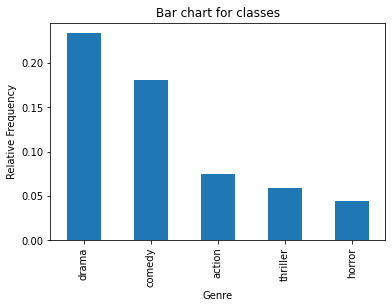

In [18]:
labels_perc[:5].plot.bar()
plt.xlabel('Genre')
plt.ylabel('Relative Frequency')
plt.title('Bar chart for classes')
plt.show()

Now we create a new dataset composed only by the 5 classes mentioned above

In [19]:
movies_edit2 = movies_edit.groupby("First_genre").filter( lambda x: len(x)>=1200)

In [20]:
movies_edit2['First_genre'].value_counts()/len(movies_edit2)

drama       0.393997
comedy      0.304252
action      0.127084
thriller    0.099631
horror      0.075036
Name: First_genre, dtype: float64

It is clear that this dataset is **not balanced**. We will asses this balancing problem later in the notebook.

## (4) Lemmatization 
We define a function to lemmatize words. 

In [21]:
movies_edit2['clean_plot']=movies_edit2['Plot'].str.lower()

In [22]:
def getLemmText(text):
 tokens=word_tokenize(text)
 lemmatizer = WordNetLemmatizer()
 tokens=[lemmatizer.lemmatize(word) for word in tokens]
 return ' '.join(tokens)

In [23]:
movies_edit2['clean_plot'] = list(map(getLemmText,movies_edit2['clean_plot']))

**Stop words**

The package nltk provide us a list of the most common words in english. We decide to add in this list some words that we've noticed are recurrent in all the plot and so are not useful for classification: 
* film
* movie
* go
* one
* two
* take
* get
* find
* back
* tell
* ha
* wa
* and other unuseful words

Our aim is remove all the stop words. 

In [24]:
movies_edit2 = movies_edit2.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;.]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = stopwords.words('english')
STOPWORDS.append('film')
STOPWORDS.append('movie')
STOPWORDS.append('one')
STOPWORDS.append('two')
STOPWORDS.append('get')
STOPWORDS.append('back')
STOPWORDS.append('tell')
STOPWORDS.append('new')
STOPWORDS.append('also')
STOPWORDS.append('time')
STOPWORDS.append('hi')
STOPWORDS.append('ha')
STOPWORDS.append('wa')
STOPWORD = set(STOPWORDS)

In [25]:
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [26]:
movies_edit2['clean_plot'] = movies_edit2['clean_plot'].apply(clean_text)
movies_edit2['clean_plot'] = movies_edit2['clean_plot'].str.replace('\d+', '')

We want to understand what are the most common stop words, we use a bar chart in order to visualize it

In [27]:
#Counting and displaying the occurrences of a list of stopwords
nlplist = []
for i in range(len(movies_edit2['Plot'])):
    nlplist.append(str(movies_edit2['Plot'][i]))
listToStr = ' '.join([str(elem) for elem in nlplist])

Dict_stop = {}
for word in STOPWORD:
     Dict_stop[word] = listToStr.count(word)

top30 =sorted(Dict_stop.items(), key=lambda x:x[1],reverse=True)[:30]


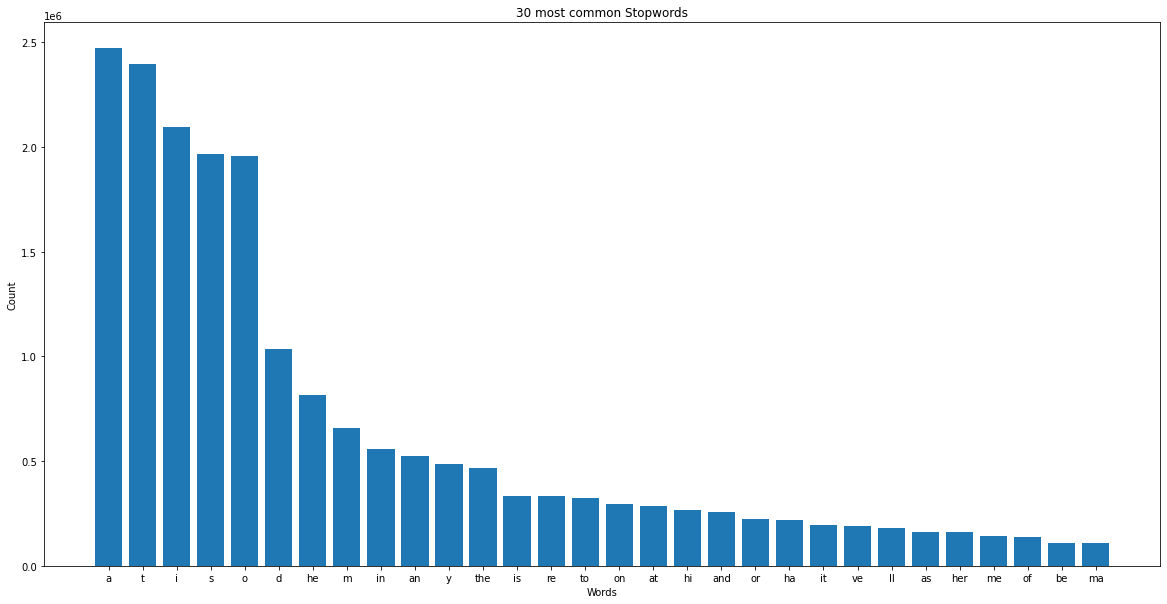

In [28]:
plt.figure(figsize=(20,10))
x,y=zip(*top30) # x is the tuple containing the 30 most common words, y is a tuple containing counts
plt.ylabel('Count')
plt.xlabel('Words')
plt.title('30 most common Stopwords')
plt.bar(x,y)
plt.show()

Counting the stopwords for each Genre
 



In [29]:
def count_stopwords(x):
    n_stopwords = 0

    for word in str(x).split(' '):
        if word in STOPWORDS:
            n_stopwords += 1

    return n_stopwords

We show how many stopwords in average per Genre are inside the 'clean_plot'.

In [30]:
movies_edit2["stopwords"] = movies_edit2["Plot"].apply(count_stopwords)

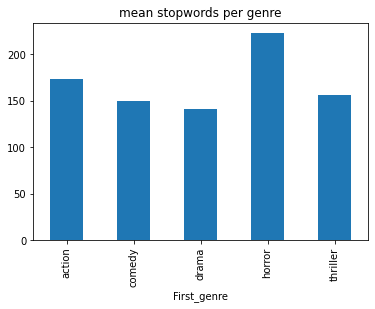

In [31]:
stopwords_label = movies_edit2.groupby(by='First_genre')['stopwords'].agg('mean')
stopwords_label.plot.bar(title = "mean stopwords per genre")
plt.show()

Now we define the function to remove all the stopwords.

In [32]:
movies_edit2.drop('index', axis = 1)

,Genre,Release Year,Plot,First_genre,clean_plot,stopwords
0,comedy,1904,The film is about a family who move to the sub...,comedy,family move suburb hoping quiet life thing sta...,15
1,comedy,1907,Before heading out to a baseball game at a nea...,comedy,heading baseball game nearby ballpark sport fa...,45
2,comedy,1907,The plot is that of a black woman going to the...,comedy,plot black woman going dentist toothache given...,21
3,drama,1908,On a beautiful summer day a father and mother ...,drama,beautiful summer day father mother take daught...,59
4,drama,1908,A thug accosts a girl as she leaves her workpl...,drama,thug accosts girl leaf workplace man rescue th...,46
...,...,...,...,...,...,...
16787,drama,2011,Hasan is a twelve-year-old boy living with his...,drama,hasan twelveyearold boy living younger sibling...,53
16788,drama,2011,"Through the night, three cars carry a small gr...",drama,night three car carry small group men police o...,412
16789,drama,2013,The film opens with a Senegalese boy named Kha...,drama,open senegalese boy named khadim told little s...,482
16790,comedy,2017,"Two musicians, Salih and Gürkan, described the...",comedy,musician salih grkan described adventure cousin,4


In the two line below we can see the differences between the starting plot and the final clean_plot.

In [33]:
print(movies_edit2.loc[1]["Plot"])

Before heading out to a baseball game at a nearby ballpark, sports fan Mr. Brown drinks several highball cocktails. He arrives at the ballpark to watch the game, but has become so inebriated that the game appears to him in reverse, with the players running the bases backwards and the baseball flying back into the pitcher's hand. After the game is over, Mr. Brown is escorted home by one of his friends. When they arrive at Brown's house, they encounter his wife who becomes furious with the friend and proceeds to physically assault him, believing he is responsible for her husband's severe intoxication.[1]


In [34]:
print(movies_edit2.loc[1]["clean_plot"])

heading baseball game nearby ballpark sport fan mr brown drink several highball cocktail arrives ballpark watch game become inebriated game appears reverse player running base backwards baseball flying pitcher hand game mr brown escorted home friend arrive brown house encounter wife becomes furious friend proceeds physically assault believing responsible husband severe intoxication 


In [35]:
list_plot = movies_edit2["clean_plot"].to_list()
len_plot = [len(str(plot).split(" ")) for plot in list_plot]

In [36]:
movies_edit2['clean_plot'] = movies_edit2['clean_plot'].apply(lambda x: str(x))

As we said before we have to balance the dataset. We have decided to undersample the dataset. Doing so we have randomly taken 1260 observations from each macro-class.

In [37]:
movies_edit3=pd.concat([movies_edit2.loc[movies_edit2["First_genre"]=="comedy"].sample(n=1260,replace=False,random_state=1200),
                        movies_edit2.loc[movies_edit2["First_genre"]=="drama"].sample(n=1260,replace=False,random_state=1200),
                        movies_edit2.loc[movies_edit2["First_genre"]=="horror"],
                        movies_edit2.loc[movies_edit2["First_genre"]=="thriller"].sample(n=1260,replace=False,random_state=1200),
                        movies_edit2.loc[movies_edit2["First_genre"]=="action"].sample(n=1260,replace=False,random_state=1200)])

In [38]:
movies_edit3['First_genre'].value_counts()/len(movies_edit3)

drama       0.2
horror      0.2
comedy      0.2
thriller    0.2
action      0.2
Name: First_genre, dtype: float64

## (5) Graphical overview


#### (5.1) **Number of movies per 5 years span**

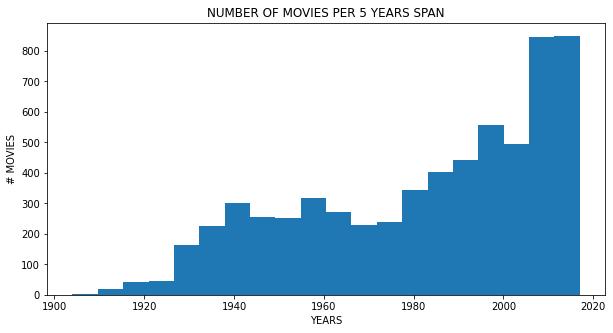

In [39]:
plt.figure(figsize=(10,5));

movies_edit3["Release Year"].plot.hist(stacked=True, bins=20)
plt.xlabel('YEARS')
plt.ylabel('# MOVIES')
plt.title('NUMBER OF MOVIES PER 5 YEARS SPAN')
plt.show()

#### (5.2) **Number of words in each plot**
The graph is in range (0,2000) to make it more readable but there are some plots with more than 4000 words.

In [40]:
list_plot = movies_edit3["Plot"].to_list()
len_plot = [len(str(plot).split(" ")) for plot in list_plot]
movies_edit3["len_plot"] = len_plot

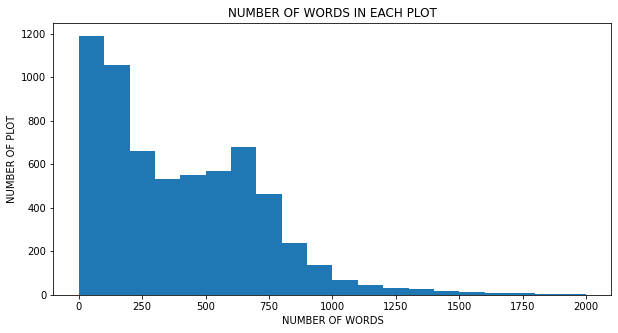

In [41]:
plt.figure(figsize=(10,5));
movies_edit3["len_plot"].plot.hist(stacked=True, bins=20, range=(0,2000))
plt.xlabel('NUMBER OF WORDS')
plt.ylabel('NUMBER OF PLOT')
plt.title('NUMBER OF WORDS IN EACH PLOT')
plt.show()

#### (5.3) **Number of words per category** 

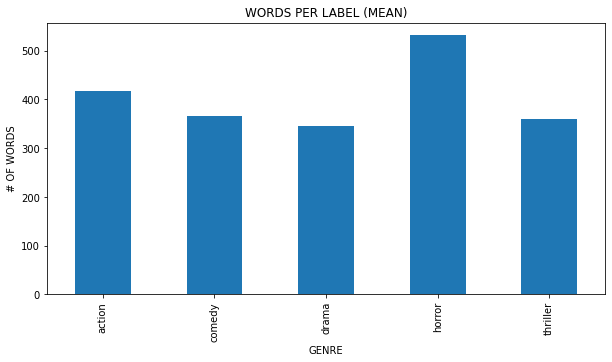

In [42]:
plt.figure(figsize=(10,5));
len_plot_label = movies_edit3.groupby(by='First_genre')['len_plot'].agg('mean')
len_plot_label.plot.bar(title = "WORDS PER LABEL (MEAN)", ylabel = '# OF WORDS', xlabel = 'GENRE')
plt.show()

#### (5.4) **Number of stopwords per Genre**

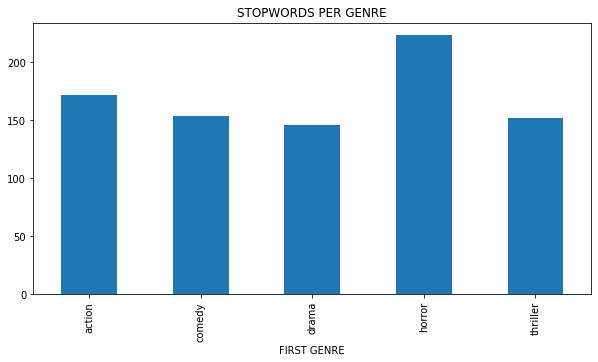

In [43]:
plt.figure(figsize=(10,5));
stopwords_label = movies_edit3.groupby(by='First_genre')['stopwords'].agg('mean')
stopwords_label.plot.bar(title = 'STOPWORDS PER GENRE')
plt.xlabel('FIRST GENRE')
plt.show()

#### (5.5) **Percentage of stopwords per Genre**

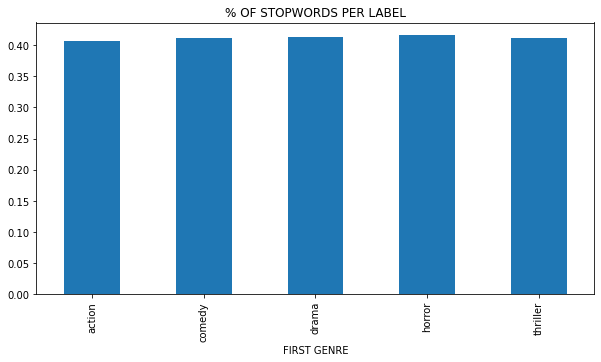

In [44]:
movies_edit3["perc_stopwords"] = movies_edit3["stopwords"]/movies_edit3["len_plot"]

plt.figure(figsize=(10,5));
stopwords_perc = movies_edit3.groupby(by='First_genre')['perc_stopwords'].agg('mean')
stopwords_perc.plot.bar(title = "% OF STOPWORDS PER LABEL")
plt.xlabel('FIRST GENRE')
plt.show()

#### (5.6) **Most used word**

In [45]:
movies_edit3 = movies_edit3.reset_index(drop=True)

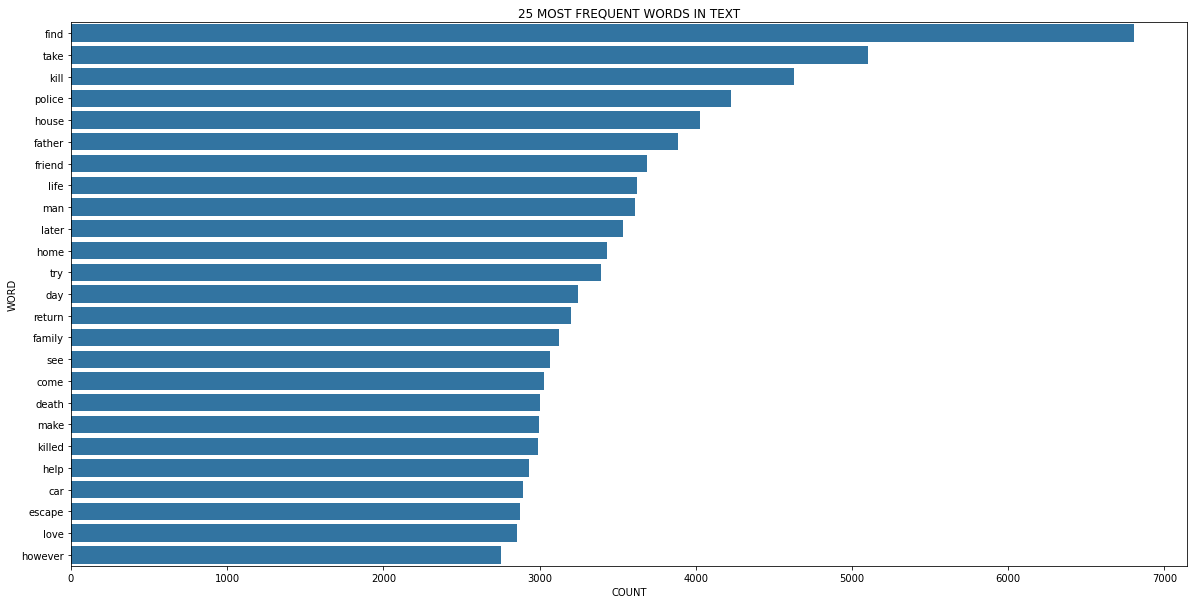

In [46]:
#which words are the most frequent in the dataset without stopwords
movies_stop = movies_edit3[['First_genre','clean_plot']].copy() #create a copy of df and removing stopwords
STOPWORDS = set(nlp.Defaults.stop_words)

movies_stop['PLOT'] = movies_stop['clean_plot'].apply(lambda x:str(x).split())

freq_words = Counter([word for text in movies_stop['PLOT'] for word in text if len(word)>2])
freq_word_df = pd.DataFrame(freq_words.most_common(150), columns=['Word','Count'])
plt.figure(figsize=(20,10));
sns.barplot(y='Word',x='Count',data=freq_word_df[:25], color= 'tab:blue').set_title("25 MOST FREQUENT WORDS IN TEXT")
plt.xlabel('COUNT')
plt.ylabel('WORD')

plt.show()

In [47]:
most_frequent = movies_edit3.groupby("First_genre")["clean_plot"].apply(lambda x: Counter(" ".join(x).split()).most_common(20))

In [48]:
genre = sorted(movies_edit3['First_genre'].unique())
for i in range(len(genre)):
  q=[]
  print(genre[i],":")
  for j in range(20):
    q.append(most_frequent[i][j][0])
  print(q)

action :
['kill', 'take', 'police', 'find', 'killed', 'go', 'escape', 'men', 'father', 'officer', 'help', 'life', 'friend', 'later', 'love', 'come', 'however', 'fight', 'brother', 'meet']
comedy :
['find', 'go', 'take', 'friend', 'love', 'father', 'home', 'make', 'life', 'day', 'try', 'money', 'woman', 'man', 'end', 'come', 'house', 'meet', 'see', 'return']
drama :
['go', 'find', 'life', 'father', 'take', 'love', 'family', 'home', 'friend', 'man', 'mother', 'day', 'return', 'later', 'come', 'make', 'wife', 'son', 'doe', 'see']
horror :
['find', 'house', 'kill', 'go', 'take', 'body', 'death', 'later', 'killed', 'try', 'see', 'night', 'room', 'home', 'begin', 'escape', 'man', 'father', 'car', 'friend']
thriller :
['police', 'find', 'go', 'kill', 'take', 'house', 'man', 'car', 'life', 'try', 'murder', 'later', 'wife', 'money', 'death', 'home', 'friend', 'killed', 'day', 'father']


## (6) Recurrent Neural Network

### (6.1) LSTM

Defining parameters

In [49]:
MAX_NB_WORDS = 6000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(movies_edit3['clean_plot'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 57497 unique tokens.


In [50]:
X = tokenizer.texts_to_sequences(movies_edit3['clean_plot'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (6300, 100)


In [51]:
Y = pd.get_dummies(movies_edit3['First_genre']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (6300, 5)


In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(5040, 100) (5040, 5)
(1260, 100) (1260, 5)


Defining model architecture:

- Embedding layer

- Dropout layer ( SpatialDropout1D will help promote independence between feature map)

- LSTM layer

- Dense layer

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [54]:
epochs = 6
batch_size = 64

#### (6.1.1) Training the model

In [55]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/6
71/71 [==============================] - 48s 606ms/step - loss: 1.5342 - accuracy: 0.2987 - val_loss: 1.3824 - val_accuracy: 0.3651
Epoch 2/6
71/71 [==============================] - 42s 595ms/step - loss: 1.2995 - accuracy: 0.4425 - val_loss: 1.3231 - val_accuracy: 0.4345
Epoch 3/6
71/71 [==============================] - 42s 597ms/step - loss: 1.0285 - accuracy: 0.5741 - val_loss: 1.2175 - val_accuracy: 0.5238
Epoch 4/6
71/71 [==============================] - 42s 596ms/step - loss: 0.7648 - accuracy: 0.7046 - val_loss: 1.4414 - val_accuracy: 0.4802
Epoch 5/6
71/71 [==============================] - 42s 594ms/step - loss: 0.5508 - accuracy: 0.8126 - val_loss: 1.3175 - val_accuracy: 0.5417
Epoch 6/6
71/71 [==============================] - 42s 595ms/step - loss: 0.3622 - accuracy: 0.8787 - val_loss: 1.4061 - val_accuracy: 0.5238


In [56]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

40/40 [==============================] - 2s 41ms/step - loss: 1.5361 - accuracy: 0.4730
Test set
  Loss: 1.536
  Accuracy: 0.473


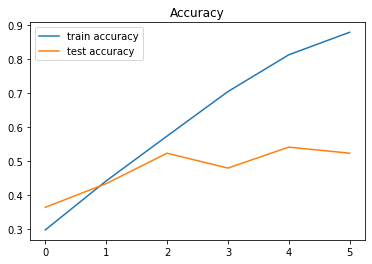

In [57]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()

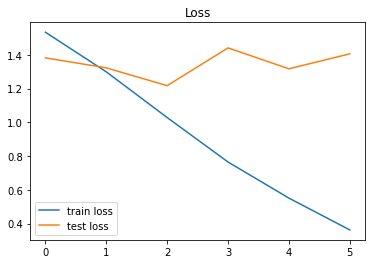

In [58]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()

In [59]:
y_predict = np.argmax(model.predict(X_test), axis=-1)
y_true = Y_test.argmax(axis=1)
label_names = movies_edit3['First_genre'].unique()

In [60]:
print(classification_report(y_true, y_predict, target_names=label_names))

              precision    recall  f1-score   support

      comedy       0.58      0.41      0.48       257
       drama       0.50      0.48      0.49       272
      horror       0.31      0.38      0.34       231
    thriller       0.75      0.68      0.71       250
      action       0.33      0.41      0.37       250

    accuracy                           0.47      1260
   macro avg       0.49      0.47      0.48      1260
weighted avg       0.50      0.47      0.48      1260



#### (6.1.2) Confusion Matrix

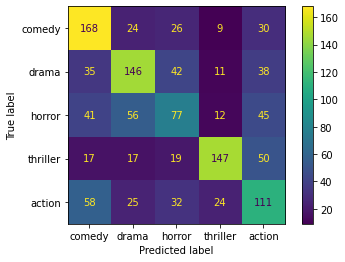

In [90]:
cm = confusion_matrix(y_true,y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = label_names)
disp.plot()
plt.show()

### (6.2) Bi-LSTM

In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [63]:
epochs = 6
batch_size = 64

#### (6.2.1) Training the model

In [64]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/6
71/71 [==============================] - 91s 1s/step - loss: 1.5506 - accuracy: 0.2639 - val_loss: 1.4217 - val_accuracy: 0.3413
Epoch 2/6
71/71 [==============================] - 84s 1s/step - loss: 1.2645 - accuracy: 0.4555 - val_loss: 1.1978 - val_accuracy: 0.5298
Epoch 3/6
71/71 [==============================] - 84s 1s/step - loss: 0.9296 - accuracy: 0.6290 - val_loss: 1.2083 - val_accuracy: 0.5000
Epoch 4/6
71/71 [==============================] - 84s 1s/step - loss: 0.6938 - accuracy: 0.7339 - val_loss: 1.3868 - val_accuracy: 0.4960
Epoch 5/6
71/71 [==============================] - 84s 1s/step - loss: 0.5092 - accuracy: 0.8100 - val_loss: 1.2522 - val_accuracy: 0.5714


In [65]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

40/40 [==============================] - 3s 79ms/step - loss: 1.3964 - accuracy: 0.5151
Test set
  Loss: 1.396
  Accuracy: 0.515


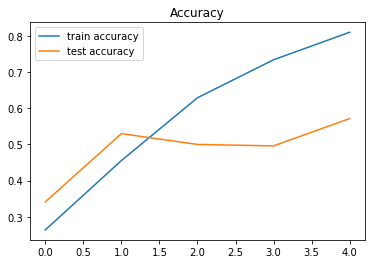

In [66]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.show()

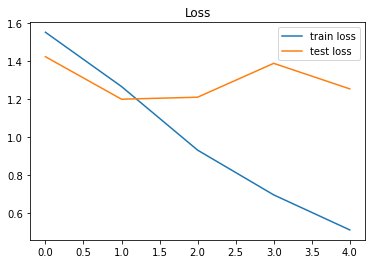

In [67]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()

In [68]:
y_predict = np.argmax(model.predict(X_test), axis=-1)
y_true = Y_test.argmax(axis=1)
label_names = movies_edit3['First_genre'].unique()

In [69]:
print(classification_report(y_true, y_predict, target_names=label_names))

              precision    recall  f1-score   support

      comedy       0.53      0.65      0.58       257
       drama       0.54      0.54      0.54       272
      horror       0.39      0.33      0.36       231
    thriller       0.72      0.59      0.65       250
      action       0.41      0.44      0.42       250

    accuracy                           0.52      1260
   macro avg       0.52      0.51      0.51      1260
weighted avg       0.52      0.52      0.51      1260



#### (6.2.2)Confusion matrix

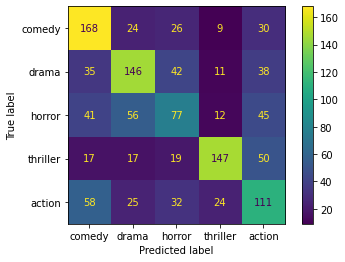

In [70]:
cm = confusion_matrix(y_true,y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = label_names)
disp.plot()
plt.show()

## (7) Bert

### (7.1) Preprocessing data
We create a new dataframe with only two columns: 
* clean_plot (our independent variable)
* First_Genre (our response)


In [71]:
df=movies_edit3[['clean_plot','First_genre']]

In [72]:
df =df.rename(columns={'clean_plot':'TITLE','First_genre':'CATEGORY'})

We define a new function to factorize each genre from 0 to 5.

In [73]:
encode_dict = {}

def encode_cat(x):
    if x not in encode_dict.keys():
        encode_dict[x]=len(encode_dict)
    return encode_dict[x]

df['ENCODE_CAT'] = df['CATEGORY'].apply(lambda x: encode_cat(x))

Defining some key variables that will be used later on in the training

In [ ]:
MAX_LEN = 100
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2 
EPOCHS = 6
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [75]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.TITLE[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.ENCODE_CAT[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

Creating the dataset and dataloader for the neural network

In [76]:
train_size = 0.6
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (6300, 3)
TRAIN Dataset: (3780, 3)
TEST Dataset: (2520, 3)


In [77]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

### (7.2) Bert Model

Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

In [78]:
class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 5)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [79]:
model = DistillBERTClass()
model.to(device)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_feat

Creating the loss function and optimizer

In [80]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

Function to calcuate the accuracy of the model

In [81]:
def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

Defining the training function on the 80% of the dataset for tuning the distilbert model

In [82]:
def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%100==0:
          loss_step = tr_loss/nb_tr_steps
          accu_step = (n_correct*100)/nb_tr_examples 
          print(f"Training Accuracy per step {nb_tr_steps}: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

#### (7.2.1) Training the model

In [83]:
for epoch in range(EPOCHS):
    train(epoch)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Training Accuracy per step 1: 0.0
Training Accuracy per step 101: 20.297029702970296
Training Accuracy per step 201: 19.029850746268657
Training Accuracy per step 301: 19.85049833887043
Training Accuracy per step 401: 20.13715710723192
Training Accuracy per step 501: 20.459081836327346
Training Accuracy per step 601: 21.00665557404326
Training Accuracy per step 701: 20.827389443651924
Training Accuracy per step 801: 20.411985018726593
Training Accuracy per step 901: 20.1165371809101
The Total Accuracy for Epoch 0: 20.158730158730158
Training Loss Epoch: 1.6130381837723746
Training Accuracy Epoch: 20.158730158730158
Training Accuracy per step 1: 25.0
Training Accuracy per step 101: 22.277227722772277
Training Accuracy per step 201: 21.890547263681594
Training Accuracy per step 301: 21.428571428571427
Training Accuracy per step 401: 22.31920199501247
Training Accuracy per step 501: 23.253493013972054
Training Accuracy per step 601: 23.668885191347755
Training Accuracy per step 701: 23.53

#### (7.2.2) Testing the model

In [84]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    nb_tr_steps=0 ;nb_tr_examples=0 ; tr_loss=0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu

#### (7.2.3) Accuracy report


In [85]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

This is the validation section to print the accuracy and see how it performs
Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Validation Loss Epoch: 1.688087804622889
Validation Accuracy Epoch: 42.53968253968254
Accuracy on test data = 42.54%


## (8) Conclusion

We work on three different architectures: 
1. LSTM
2. Bi-LSTM
3. BERT 

The first two architecture gave us very similar output but Bi-LSTM performed better, indeed we reach an accuracy of 52%, 4% better than the LSTM. 

Even after dropping the most recurrent words each plot has similar text. Moreover there isn't a common link between the same genre

As comparison we have used accuracy for all 3 models.

BERT gave us a slightly worse result: only 42,54% of test accuracy. The problem could be discernible from the fact that we have used only 6 epochs to have a comparison between models and BERT's response is less functional than the response of other two models. 


All the models that we reported here don't have an accuracy as high as in other examples of text classification. This is due to the fact that the original classification in the dataset is not as specific as it should be. A lot of movies have more than 1 genre and the classification is very broad in terms of different genre taken into consideration. Moreover the genre that we choose are slightly similar (i.e. for the thriller, action and horror  genres the difference in the plots is not as marked as it should be in order to train a well-prepared model for classification) in terms of plots. 

Summing up we are happy with the results that we have obtained and we think this has been a valuable exercise for our future experiences.